In [35]:
import numpy as np
import os, sys
import lalsimulation as lalsim
import lal
from scipy.interpolate import interp1d

%matplotlib inline
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

sys.path.append('../../../..')
import MonashGWTools.waveforms as wv
import MonashGWTools.tools as tools

In [2]:
def snr_matchedfilter(hf, muf, f, Sh):
    '''                                                                                                            
    eric.thrane@ligo.org                                                                                           
    calculate matched filter SNR for template muf given data hf                                                    
    '''
    snr = tools.inner_product(hf, muf, f, Sh) / np.sqrt(tools.inner_product(muf, muf, f, Sh))
    return snr

In [3]:
def gen_waveform(phiRef, deltaF, m1, m2, fmin, fmax, iota, dist, inc_azim, e_min):

    fref = 10.
    m1 *= lal.lal.MSUN_SI
    m2 *= lal.lal.MSUN_SI
    dist = 1e6*lal.lal.PC_SI*dist
    phaseO = -1
    
    approx = lalsim.GetApproximantFromString("EccentricFD")
    meanPerAno = 0
    longAscNodes = 0
    
    WFdict = lal.CreateDict()
    
    #H = lalsim.SimInspiralFD(phiRef, deltaF, m1, m2, fmin, fmax, iota, dist, inc_azim, e_min, phaseO)
    H = lalsim.SimInspiralChooseFDWaveform(m1, m2, 0, 0, 0, 0, 0, 0, dist, iota, phiRef, longAscNodes, e_min, meanPerAno, deltaF, fmin, fmax, fref, WFdict, approx)
    hplus = H[0].data.data
    hcross = H[1].data.data

    
    
    return hplus, hcross



#/bin/lalsim-inspiral -P -a EccentricFD -O -1 -u 0 -f 10 -e 0.1 -R 1024. -m1 35 -m2 30 -i 0 -d 400

In [4]:
def detector_strain(h_p, h_c, RA, DEC, psi, epoch):
    
    tgps = lal.LIGOTimeGPS(epoch)
    gmst = lal.GreenwichMeanSiderealTime(tgps)
    
    # Antenna response:
    fplus, fcross = wv.AntennaResponse(RA, DEC, psi, epoch, ifo='H1')
    diff = lal.LALDetectorIndexLHODIFF
    
    timedelay = lal.TimeDelayFromEarthCenter(lal.CachedDetectors[diff].location, RA, DEC, tgps)
    timeshift = epoch + timedelay
    
    #Calculate the observed strain at the detector, properly shifting the waveform from geocenter to detector frame.
    h = np.zeros_like(h_p, dtype=complex)
    pit = np.pi*timeshift
    if timeshift != 0.0:
        shift = complex(1.0, 0)
        dshift = complex(-2.*np.sin(pit*deltaF)*np.sin(pit*deltaF), -2.*np.sin(pit*deltaF)*np.cos(pit*deltaF))
        for i in xrange(0,h_p.size):
            h[i] = shift*(fplus*h_p[i] + fcross*h_c[i])
            shift += shift*dshift
    else: h = (fplus*h_p) + (fcroh_c)
        
    return h


In [5]:
phiRef = 0.
fmin = 10.
fmax = 1024.
deltaF = 1./4.
Fsh = 2*fmax
m1 = 40.
m2 = 35.
dist = 300.
iota = 20.
inc_azim = 0.
e_min = 0.4

RA = 20.9375
DEC = 45.
psi = 0.

epoch = 1000000004

In [6]:
hplus,hcross = gen_waveform(phiRef, deltaF, m1, m2, fmin, fmax, iota, dist, inc_azim, e_min)

htilde = detector_strain(hplus, hcross, RA, DEC, psi, epoch)

q_t = tools.infft(htilde,Fsh)

In [7]:
ff = np.linspace(0,fmax,len(htilde))

In [8]:
data_file = np.loadtxt('injections/injection.dat')
data = data_file[:,1]
Fs = 1/(data_file[1,0].real - data_file[0,0].real)

FFTdata, freq = tools.nfft(data,Fs)

noise_file = np.loadtxt('injections/noise.dat')
noise = noise_file[:,1]

PSD_file = np.column_stack( np.loadtxt("../../../../MonashGWTools/NoiseCurves/aLIGO_ZERO_DET_high_P_asd.txt") )
PSD_interp_funct = interp1d(PSD_file[0,:], PSD_file[1,:], bounds_error=False, fill_value=np.inf)
PSD = PSD_interp_funct(freq)

divData = FFTdata/np.sqrt(PSD)

whitened_data = tools.infft(divData,Fs)

plt.plot(data_file[:,0],whitened_data)
plt.axvline(4.2+1e9,color='r')
plt.axvline(2.2+1e9,color='r')
plt.ylim(-0.5e-9,0.5e-9)
plt.xlabel('time')
plt.ylabel('strain')
plt.tight_layout()
plt.savefig('whitened_strain.png',dpi=200)
plt.show()

IOError: [Errno 2] No such file or directory: 'injections/injection.dat'

In [9]:
Fsn = 1/(noise_file[1,0].real - noise_file[0,0].real)
FFTnoise, nfreq = tools.nfft(noise,Fsn)

divNoise = FFTnoise/np.sqrt(PSD)

whitened_noise = tools.infft(divNoise,Fsn)

plt.hist(whitened_noise,bins=100)
plt.title('Binned whitened noise')
plt.xlabel('strain')
plt.ylabel('histogram counts')
plt.tight_layout()
plt.savefig('binned_noise.png',dpi=200)
plt.show()

NameError: name 'noise_file' is not defined

In [10]:
tools.snr_exp(FFTdata,freq,PSD_file)

NameError: name 'FFTdata' is not defined

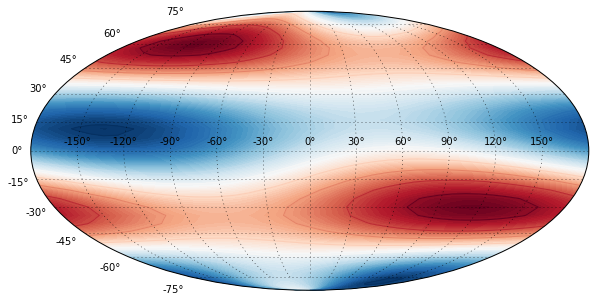

In [28]:
ra = np.linspace(-np.pi, np.pi, 40)
dec= np.linspace(-np.pi/2, np.pi/2, 40)

Fp = np.zeros((len(ra),len(dec)))
Fc = np.zeros((len(ra),len(dec)))

for i in range(0,len(ra)):
    for k in range(0,len(dec)):
        Fp[i,k], Fc[i,k] = wv.AntennaResponse(ra[i], dec[k], 0, 1000000000, ifo='H1')

X,Y = np.meshgrid(ra,dec)

H1 = Fp + Fc

plt.figure(1,(10,10))
ax = plt.subplot(111, projection = 'mollweide')
ax.contourf(X,Y,Fp,100,cmap='RdBu')
ax.contour(X,Y,Fp,10,cmap='RdBu')
ax.grid()

plt.show(1)

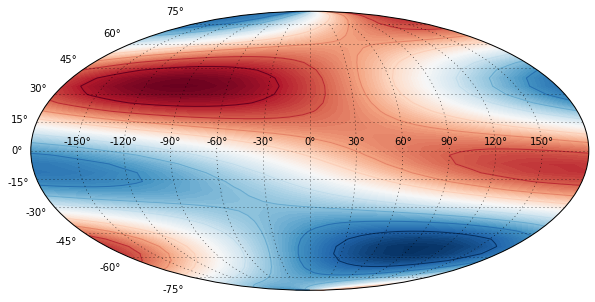

In [29]:
plt.figure(1,(10,10))
ax = plt.subplot(111, projection = 'mollweide')
ax.contourf(X,Y,Fc,100,cmap='RdBu')
ax.contour(X,Y,Fc,10,cmap='RdBu')
ax.grid()
plt.show(1)

In [155]:
import pickle

In [156]:
x = np.arange(1,10,20)

In [157]:
with open('test.pickle', 'wb') as handle:
    pickle.dump(x, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [161]:
with open('test.pickle', 'rb') as handle:
    b = pickle.load(handle)

In [162]:
b == x

array([ True], dtype=bool)

In [36]:
np.log10(0)

/cvmfs/oasis.opensciencegrid.org/ligo/deploy/sw/pycbc/x86_64_rhel_7/virtualenv/pycbc-v1.8.0/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


-inf